In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import scipy.stats as stats 
import itertools
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N)
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
def remove_trials_with_exceptions(df):
  return df.groupby(['trial']).filter(lambda x : len(x) >= 10 * 2).reset_index(drop = True)

In [5]:
def get_best_results(dataset, gnn, llm, method, aggregation, target_metric):
  df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


# RQ 2

---------

## SST-2

In [6]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Layer-wise_Aggregation', target_metric = 'accuracy')

number                                     213
value                                 0.911697
params_attention_heads                      13
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          128
params_beta_0                          0.86738
params_beta_1                         0.980849
params_dropout_rate                   0.326602
params_early_stopping_patience              20
params_embedding_pooling_operation        mean
params_epochs                              128
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                     47
params_learning_rate                  0.004256
params_number_of_hidden_layers               2
params_plateau_divider                       7
params_plateau_patience                     14
params_threshold                      0.428184
params_weight_decay                   0.000022
user_attrs_ep

In [7]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Global_Aggregation', target_metric = 'accuracy')

number                                      35
value                                  0.91055
params_attention_heads                      11
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                          138
params_beta_0                          0.88444
params_beta_1                         0.990712
params_dropout_rate                   0.421163
params_early_stopping_patience              20
params_embedding_pooling_operation         min
params_epochs                              129
params_epsilon                        0.000016
params_global_pooling                      max
params_hidden_dimension                    190
params_learning_rate                  0.000747
params_number_of_hidden_layers               2
params_plateau_divider                       6
params_plateau_patience                     11
params_threshold                      0.641679
params_weight_decay                   0.000481
user_attrs_ep

---------

## R8

In [8]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Layer-wise_Aggregation', target_metric = 'f1_score')

number                                     103
value                                  0.96414
params_attention_heads                      10
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           80
params_beta_0                         0.810881
params_beta_1                         0.992833
params_dropout_rate                   0.434553
params_early_stopping_patience              22
params_embedding_pooling_operation         min
params_epochs                              186
params_epsilon                        0.000015
params_global_pooling                     mean
params_hidden_dimension                    133
params_learning_rate                  0.000457
params_left_stride                           0
params_number_of_hidden_layers               1
params_plateau_divider                      10
params_plateau_patience                     13
params_right_stride                         64
params_thresh

In [9]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Global_Aggregation', target_metric = 'f1_score')

number                                     211
value                                 0.965471
params_attention_heads                      10
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           76
params_beta_0                         0.899868
params_beta_1                         0.996723
params_dropout_rate                   0.505127
params_early_stopping_patience              19
params_embedding_pooling_operation        mean
params_epochs                               64
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    149
params_learning_rate                  0.000509
params_left_stride                          32
params_number_of_hidden_layers               1
params_plateau_divider                       8
params_plateau_patience                     22
params_right_stride                          0
params_thresh

## Ohsumed

In [10]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Layer-wise_Aggregation', target_metric = 'f1_score')

number                                      91
value                                 0.647956
params_attention_heads                       9
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           59
params_beta_0                         0.843587
params_beta_1                         0.997895
params_dropout_rate                   0.479669
params_early_stopping_patience              22
params_embedding_pooling_operation        mean
params_epochs                               97
params_epsilon                        0.000034
params_global_pooling                      max
params_hidden_dimension                    110
params_learning_rate                  0.000469
params_left_stride                          32
params_number_of_hidden_layers               2
params_plateau_divider                       5
params_plateau_patience                     12
params_right_stride                         32
params_thresh

In [11]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Global_Aggregation', target_metric = 'f1_score')

number                                     240
value                                 0.653879
params_attention_heads                      15
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           56
params_beta_0                         0.868298
params_beta_1                          0.98596
params_dropout_rate                   0.365742
params_early_stopping_patience              24
params_embedding_pooling_operation        mean
params_epochs                               97
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    240
params_learning_rate                  0.000177
params_left_stride                           0
params_number_of_hidden_layers               2
params_plateau_divider                       7
params_plateau_patience                     21
params_right_stride                        256
params_thresh

## IMDb Top 1k

In [12]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Layer-wise_Aggregation', target_metric = 'accuracy')

number                                     174
value                                 0.927273
params_attention_heads                       8
params_attention_pooling_operation         min
params_balanced_loss                      True
params_batch_size                           26
params_beta_0                         0.808292
params_beta_1                         0.985742
params_dropout_rate                   0.439228
params_early_stopping_patience              13
params_embedding_pooling_operation         min
params_epochs                              179
params_epsilon                          0.0001
params_global_pooling                     mean
params_hidden_dimension                    125
params_learning_rate                  0.000564
params_left_stride                         128
params_number_of_hidden_layers               0
params_plateau_divider                      10
params_plateau_patience                     19
params_right_stride                         64
params_thresh

In [13]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'Global_Aggregation', target_metric = 'accuracy')

number                                     214
value                                 0.927273
params_attention_heads                       5
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                           20
params_beta_0                         0.855017
params_beta_1                         0.983116
params_dropout_rate                   0.439456
params_early_stopping_patience              13
params_embedding_pooling_operation         min
params_epochs                              159
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    123
params_learning_rate                  0.000814
params_left_stride                         128
params_number_of_hidden_layers               0
params_plateau_divider                       9
params_plateau_patience                     11
params_right_stride                         64
params_thresh

## Visual analysis

In [14]:
def get_best_results_for_plot(datasets, gnns, llm, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for method in methods:
        for aggregation in aggregations:
          df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
          df = remove_trials_with_exceptions(df)
          df_aggregated = df.groupby(['trial', 'split']).agg({
            'accuracy' : ['mean', 'std'],
            'f1_score' : ['mean', 'std'],
            'precision' : ['mean', 'std'],
            'recall' : ['mean', 'std'],
          }).reset_index()
          df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
          
          best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

          best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

          best_trial_validation = best_trial[best_trial['split'] == 'validation']
          best_trial_test = best_trial[best_trial['split'] == 'test']

          results.append((dataset, target_metric, gnn, method, aggregation, best_trial_validation['accuracy_mean'].values[0], best_trial_validation['accuracy_std'].values[0], \
            best_trial_validation['f1_score_mean'].values[0], best_trial_validation['f1_score_std'].values[0], \
            best_trial_validation['precision_mean'].values[0], best_trial_validation['precision_std'].values[0], \
            best_trial_validation['recall_mean'].values[0], best_trial_validation['recall_std'].values[0], \
            best_trial_test['accuracy_mean'].values[0], best_trial_test['accuracy_std'].values[0], \
            best_trial_test['f1_score_mean'].values[0], best_trial_test['f1_score_std'].values[0], \
            best_trial_test['precision_mean'].values[0], best_trial_test['precision_std'].values[0], \
            best_trial_test['recall_mean'].values[0], best_trial_test['recall_std'].values[0]))
  return pd.DataFrame(
    results,
    columns = ['dataset', 'target_metric', 'gnn', 'method', 'aggregation', 'validation_accuracy_mean', 'validation_accuracy_std', 'validation_f1_score_mean', 'validation_f1_score_std', \
              'validation_precision_mean', 'validation_precision_std', 'validation_recall_mean', 'validation_recall_std', 'test_accuracy_mean', 'test_accuracy_std', \
              'test_f1_score_mean', 'test_f1_score_std', 'test_precision_mean', 'test_precision_std', 'test_recall_mean', 'test_recall_std']
  )

In [15]:
best_results_df = get_best_results_for_plot(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped'],
  aggregations = ['No_Aggregation', 'Layer-wise_Aggregation', 'Global_Aggregation']
)

In [16]:
best_results_df

,dataset,target_metric,gnn,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,0.902460,...,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
1,SST-2,accuracy,GATv2,Grouped,Layer-wise_Aggregation,0.901261,0.005170,0.901223,0.005174,0.901805,...,0.901416,0.005070,0.891543,0.003571,0.891506,0.003576,0.892055,0.003589,0.891534,0.003576
2,SST-2,accuracy,GATv2,Grouped,Global_Aggregation,0.900115,0.004473,0.900097,0.004473,0.900571,...,0.900369,0.004494,0.890774,0.005148,0.890730,0.005161,0.891375,0.005009,0.890766,0.005151
3,R8,f1_score,GATv2,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,0.949558,...,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
4,R8,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.978396,0.002508,0.950440,0.006942,0.947282,...,0.955435,0.008177,0.977707,0.005439,0.946577,0.008608,0.950923,0.008842,0.944338,0.008020
5,R8,f1_score,GATv2,Grouped,Global_Aggregation,0.977393,0.004336,0.953875,0.005293,0.949840,...,0.960455,0.007826,0.976062,0.006364,0.941531,0.010567,0.945307,0.012858,0.941113,0.009748
6,Ohsumed,f1_score,GATv2,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,0.670270,...,0.634265,0.011414,0.699629,0.005115,0.613479,0.005422,0.622005,0.007952,0.616470,0.005330
7,Ohsumed,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.700149,0.007366,0.625782,0.012595,0.654602,...,0.624280,0.011946,0.694286,0.008635,0.607502,0.010162,0.613126,0.011105,0.613835,0.008708
8,Ohsumed,f1_score,GATv2,Grouped,Global_Aggregation,0.711458,0.008718,0.632150,0.009684,0.681068,...,0.625070,0.008826,0.700940,0.006846,0.613550,0.008459,0.635337,0.010299,0.609280,0.010835
9,IMDb-top_1000,accuracy,GATv2,Grouped,No_Aggregation,0.912121,0.009999,0.911400,0.010187,0.913834,...,0.910308,0.010626,0.922687,0.008611,0.922427,0.008658,0.922450,0.008384,0.923247,0.008740


## Rank analysis

In [17]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_rank'] = best_results_df[['dataset', column]].groupby(['dataset']).rank(method = 'max', ascending = False)

In [18]:
best_results_df

,dataset,target_metric,gnn,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,...,test_recall_mean,test_recall_std,validation_accuracy_mean_rank,validation_f1_score_mean_rank,validation_precision_mean_rank,validation_recall_mean_rank,test_accuracy_mean_rank,test_f1_score_mean_rank,test_precision_mean_rank,test_recall_mean_rank
0,SST-2,accuracy,GATv2,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,0.902460,...,0.895169,0.007484,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,SST-2,accuracy,GATv2,Grouped,Layer-wise_Aggregation,0.901261,0.005170,0.901223,0.005174,0.901805,...,0.891534,0.003576,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,SST-2,accuracy,GATv2,Grouped,Global_Aggregation,0.900115,0.004473,0.900097,0.004473,0.900571,...,0.890766,0.005151,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,R8,f1_score,GATv2,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,0.949558,...,0.944694,0.006340,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0
4,R8,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.978396,0.002508,0.950440,0.006942,0.947282,...,0.944338,0.008020,1.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0
5,R8,f1_score,GATv2,Grouped,Global_Aggregation,0.977393,0.004336,0.953875,0.005293,0.949840,...,0.941113,0.009748,3.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0
6,Ohsumed,f1_score,GATv2,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,0.670270,...,0.616470,0.005330,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0
7,Ohsumed,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.700149,0.007366,0.625782,0.012595,0.654602,...,0.613835,0.008708,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
8,Ohsumed,f1_score,GATv2,Grouped,Global_Aggregation,0.711458,0.008718,0.632150,0.009684,0.681068,...,0.609280,0.010835,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0
9,IMDb-top_1000,accuracy,GATv2,Grouped,No_Aggregation,0.912121,0.009999,0.911400,0.010187,0.913834,...,0.923247,0.008740,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0


In [19]:
best_results_df_grouped = best_results_df.groupby(['aggregation']).agg({
  'validation_accuracy_mean_rank' : ['mean', 'std'],
  'test_accuracy_mean_rank' : ['mean', 'std'],
  'validation_f1_score_mean_rank' : ['mean', 'std'],
  'test_f1_score_mean_rank' : ['mean', 'std'],
  'validation_precision_mean_rank' : ['mean', 'std'],
  'test_precision_mean_rank' : ['mean', 'std'],
  'validation_recall_mean_rank' : ['mean', 'std'],
  'test_recall_mean_rank' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [20]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['aggregation'], var_name = 'information', value_name = 'value') # .drop(columns = ['gnn', 'method'])
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [21]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['aggregation', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [22]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [23]:
best_results_df_grouped.head()

mean_std,aggregation,split,metric,mean,std,label
0,Global_Aggregation,test,accuracy,2.50,1.0,2.50 ± 1.00
1,Global_Aggregation,test,f1,2.50,1.0,2.50 ± 1.00
2,Global_Aggregation,test,precision,2.50,1.0,2.50 ± 1.00
3,Global_Aggregation,test,recall,3.00,0.0,3.00 ± 0.00
4,Global_Aggregation,validation,accuracy,2.75,0.5,2.75 ± 0.50


In [24]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [25]:
best_results_df_grouped['aggregation'] = best_results_df_grouped['aggregation'].replace({'Global_Aggregation' : 'Global', 'Layer-wise_Aggregation' : 'Layer-wise', 'No_Aggregation' : 'None'})

In [26]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

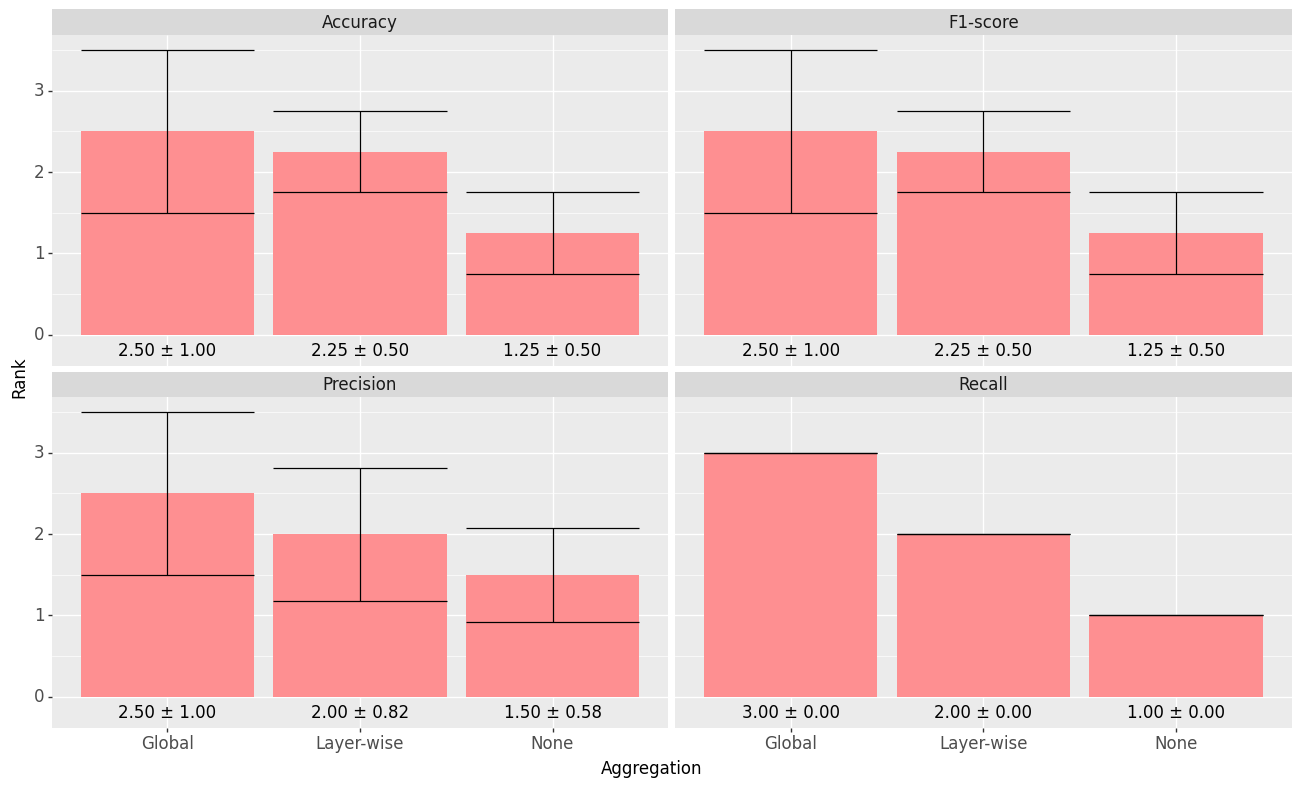

<ggplot: (814710682)>

In [27]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'aggregation', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.2, label = 'label'), position = p9.position_dodge2(width = .9), size = 12) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

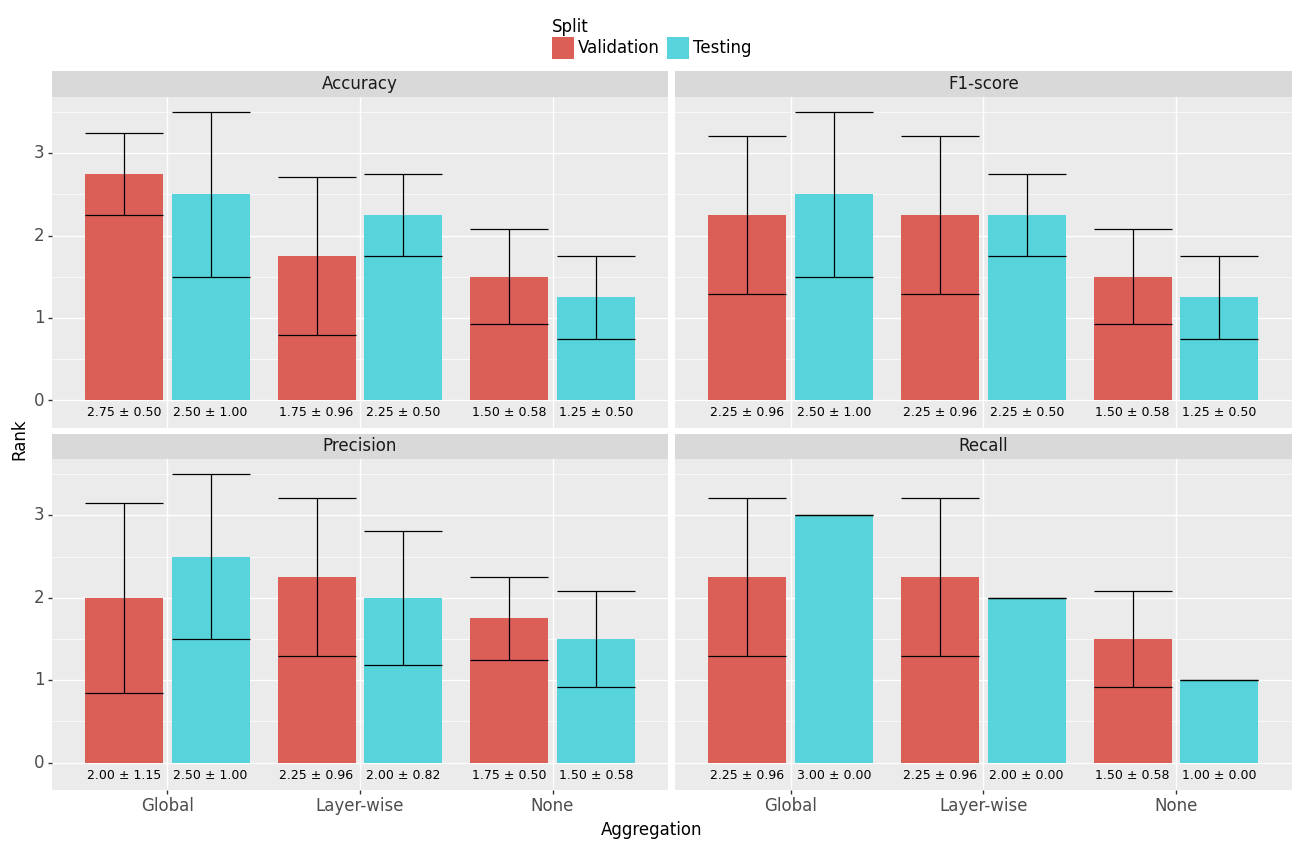

<ggplot: (814429653)>

In [28]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'aggregation', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

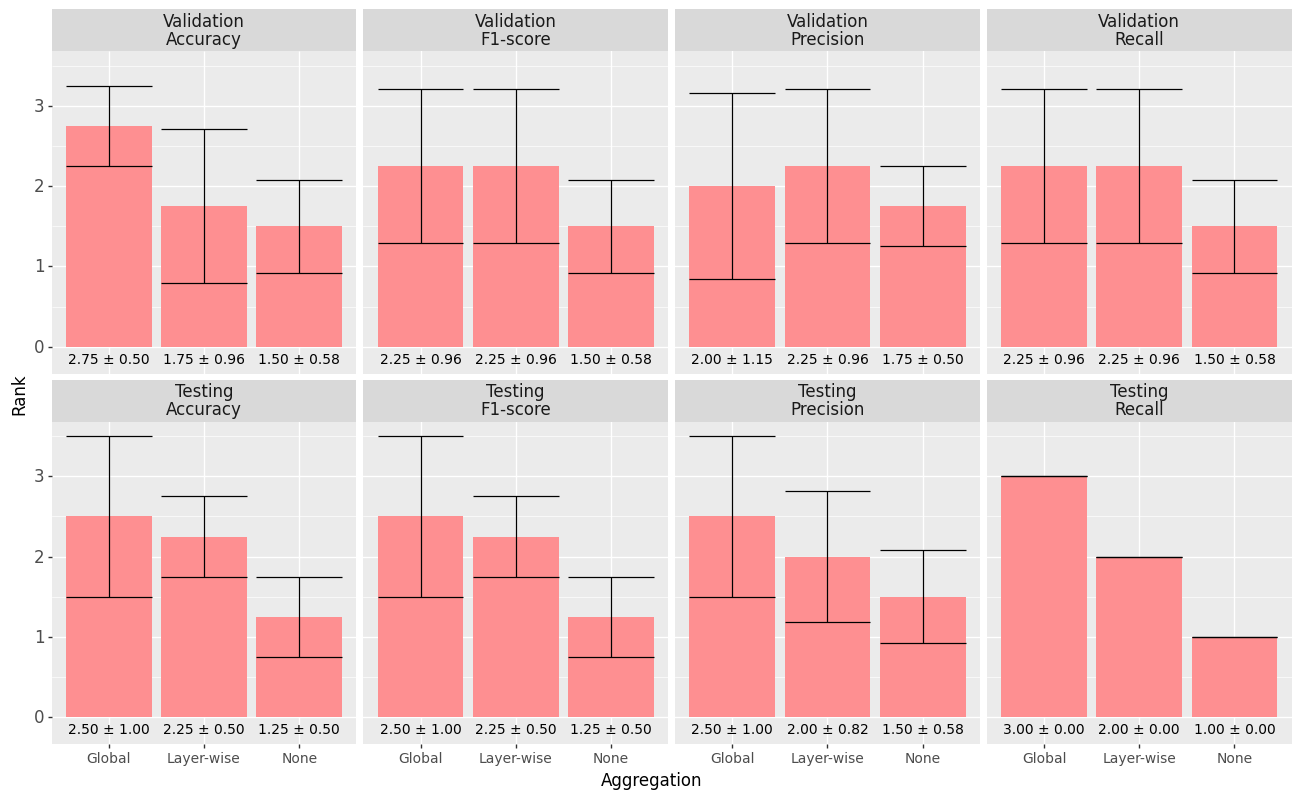

<ggplot: (813828069)>

In [29]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'aggregation', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Rank') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10)
  )

## Percentage change analysis

In [30]:
best_results_df.drop(columns = [x for x in best_results_df.columns if x.endswith('_rank')], inplace = True)

In [31]:
best_results_df

,dataset,target_metric,gnn,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,0.902460,...,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
1,SST-2,accuracy,GATv2,Grouped,Layer-wise_Aggregation,0.901261,0.005170,0.901223,0.005174,0.901805,...,0.901416,0.005070,0.891543,0.003571,0.891506,0.003576,0.892055,0.003589,0.891534,0.003576
2,SST-2,accuracy,GATv2,Grouped,Global_Aggregation,0.900115,0.004473,0.900097,0.004473,0.900571,...,0.900369,0.004494,0.890774,0.005148,0.890730,0.005161,0.891375,0.005009,0.890766,0.005151
3,R8,f1_score,GATv2,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,0.949558,...,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
4,R8,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.978396,0.002508,0.950440,0.006942,0.947282,...,0.955435,0.008177,0.977707,0.005439,0.946577,0.008608,0.950923,0.008842,0.944338,0.008020
5,R8,f1_score,GATv2,Grouped,Global_Aggregation,0.977393,0.004336,0.953875,0.005293,0.949840,...,0.960455,0.007826,0.976062,0.006364,0.941531,0.010567,0.945307,0.012858,0.941113,0.009748
6,Ohsumed,f1_score,GATv2,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,0.670270,...,0.634265,0.011414,0.699629,0.005115,0.613479,0.005422,0.622005,0.007952,0.616470,0.005330
7,Ohsumed,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.700149,0.007366,0.625782,0.012595,0.654602,...,0.624280,0.011946,0.694286,0.008635,0.607502,0.010162,0.613126,0.011105,0.613835,0.008708
8,Ohsumed,f1_score,GATv2,Grouped,Global_Aggregation,0.711458,0.008718,0.632150,0.009684,0.681068,...,0.625070,0.008826,0.700940,0.006846,0.613550,0.008459,0.635337,0.010299,0.609280,0.010835
9,IMDb-top_1000,accuracy,GATv2,Grouped,No_Aggregation,0.912121,0.009999,0.911400,0.010187,0.913834,...,0.910308,0.010626,0.922687,0.008611,0.922427,0.008658,0.922450,0.008384,0.923247,0.008740


In [32]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GATv2') & (best_results_df['method'] == 'Grouped') & (best_results_df['aggregation'] == 'No_Aggregation')

In [33]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [34]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [35]:
best_results_df

,dataset,target_metric,gnn,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,validation_precision_mean,...,test_recall_std,is_base,validation_accuracy_mean_change,validation_f1_score_mean_change,validation_precision_mean_change,validation_recall_mean_change,test_accuracy_mean_change,test_f1_score_mean_change,test_precision_mean_change,test_recall_mean_change
1,SST-2,accuracy,GATv2,Grouped,Layer-wise_Aggregation,0.901261,0.005170,0.901223,0.005174,0.901805,...,0.003576,False,0.199336,0.174250,0.444584,0.107000,-0.097056,-0.094508,-0.085363,-0.077383
2,SST-2,accuracy,GATv2,Grouped,Global_Aggregation,0.900115,0.004473,0.900097,0.004473,0.900571,...,0.005151,False,-0.797342,-0.798017,-0.830106,-0.775747,-0.905856,-0.893527,-0.873084,-0.789155
4,R8,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.978396,0.002508,0.950440,0.006942,0.947282,...,0.008020,False,-2.142263,-1.765432,-2.337636,-1.574224,-0.763629,-0.974291,-1.427402,-0.427440
5,R8,f1_score,GATv2,Grouped,Global_Aggregation,0.977393,0.004336,0.953875,0.005293,0.949840,...,0.009748,False,-0.561564,-0.765701,1.610988,-1.449662,0.187372,0.011430,2.143364,-1.166223
7,Ohsumed,f1_score,GATv2,Grouped,Layer-wise_Aggregation,0.700149,0.007366,0.625782,0.012595,0.654602,...,0.008708,False,0.027959,-0.288763,-0.239685,-0.325639,-0.079369,-0.002870,0.078196,-0.037611
8,Ohsumed,f1_score,GATv2,Grouped,Global_Aggregation,0.711458,0.008718,0.632150,0.009684,0.681068,...,0.010835,False,-0.074557,0.071523,0.029778,0.198015,-0.247444,-0.535934,-0.512877,-0.379043
10,IMDb-top_1000,accuracy,GATv2,Grouped,Layer-wise_Aggregation,0.913939,0.006259,0.912989,0.006675,0.917897,...,0.007632,False,-0.114387,-0.116664,-0.072520,-0.112309,-0.404883,-0.407625,-0.367940,-0.406036
11,IMDb-top_1000,accuracy,GATv2,Grouped,Global_Aggregation,0.904848,0.011446,0.904127,0.011579,0.906249,...,0.008478,False,-0.241484,-0.241373,-0.209273,-0.228234,-0.490767,-0.494283,-0.443924,-0.491839


In [36]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric', 'gnn', 'method']).melt(id_vars = ['aggregation'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [37]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['aggregation'] = best_results_df_melted['aggregation'].replace({'Global_Aggregation' : 'Global', 'Layer-wise_Aggregation' : 'Layer-wise', 'No_Aggregation' : 'None'})
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [38]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

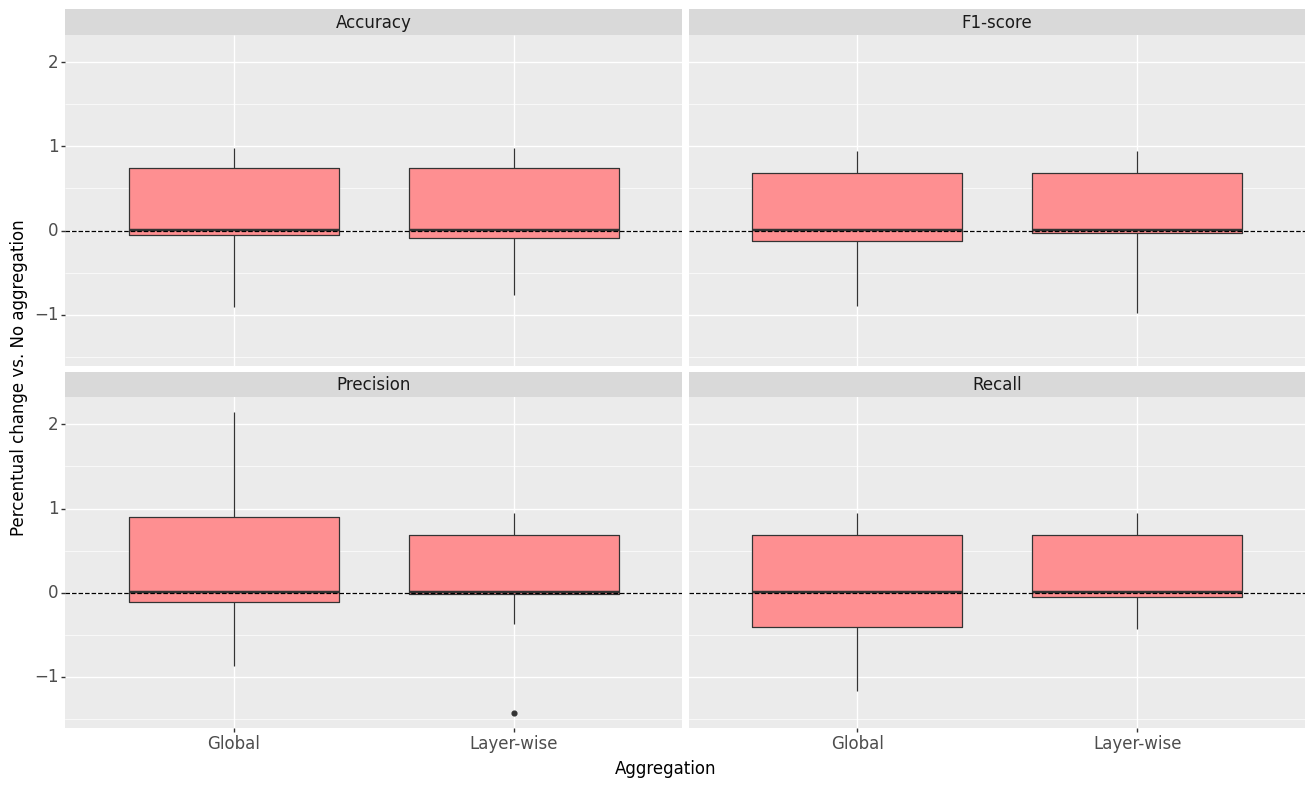

<ggplot: (814977664)>

In [39]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'aggregation', y = 'value', group = 'aggregation')) + \
  p9.theme_gray() + \
  p9.geom_boxplot(fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Percentual change vs. No aggregation') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [40]:
best_results_df_grouped = best_results_df.groupby(['aggregation']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [41]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['aggregation'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [42]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['aggregation', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [43]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [44]:
best_results_df_grouped.head()

mean_std,aggregation,split,metric,mean,std,label
0,Global_Aggregation,test,accuracy,-0.364174,0.457265,-0.36 ± 0.46
1,Global_Aggregation,test,f1,-0.478079,0.372302,-0.48 ± 0.37
2,Global_Aggregation,test,precision,0.078370,1.389464,0.08 ± 1.39
3,Global_Aggregation,test,recall,-0.706565,0.351892,-0.71 ± 0.35
4,Global_Aggregation,validation,accuracy,-0.418737,0.323326,-0.42 ± 0.32


In [45]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_grouped['aggregation'] = best_results_df_grouped['aggregation'].replace({'Global_Aggregation' : 'Global', 'Layer-wise_Aggregation' : 'Layer-wise', 'No_Aggregation' : 'None'})

In [46]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

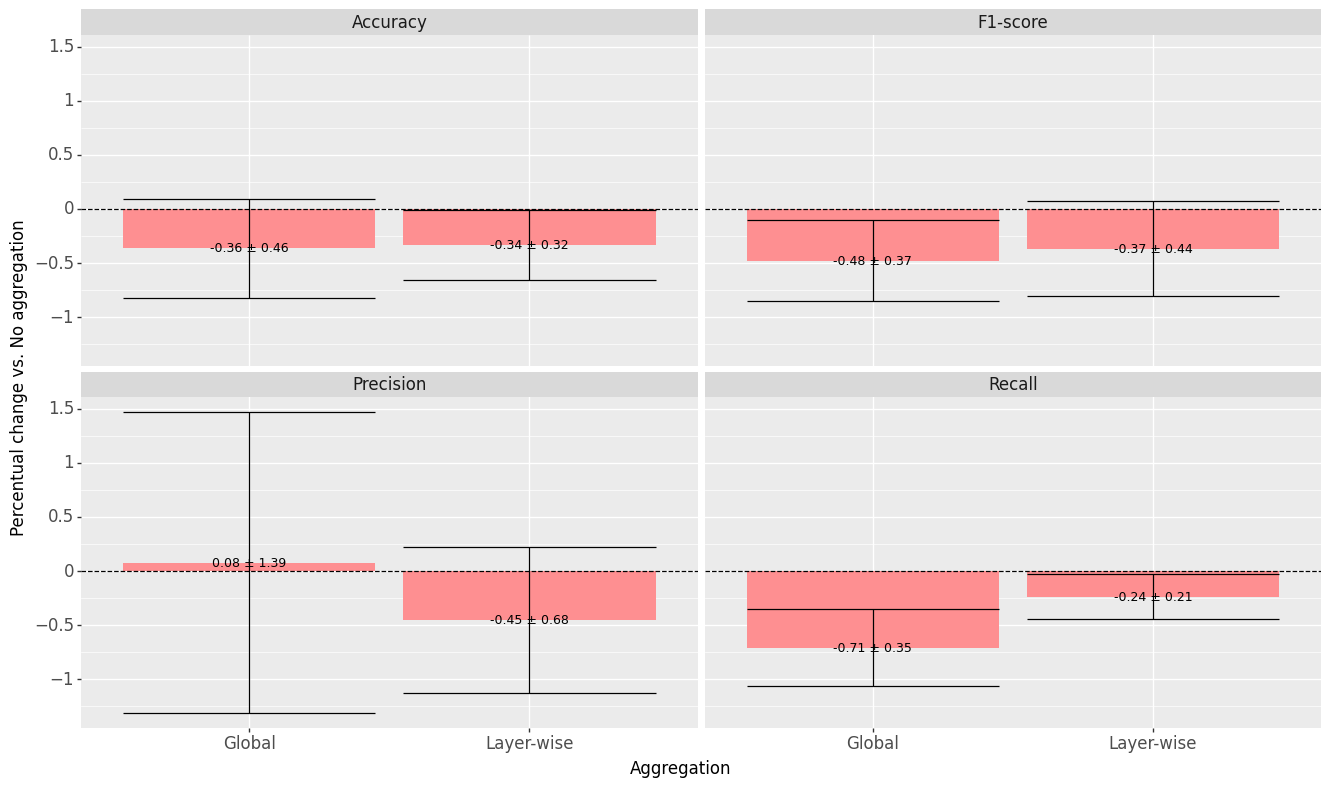

<ggplot: (814304707)>

In [47]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'aggregation', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Percentual change vs. No aggregation') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

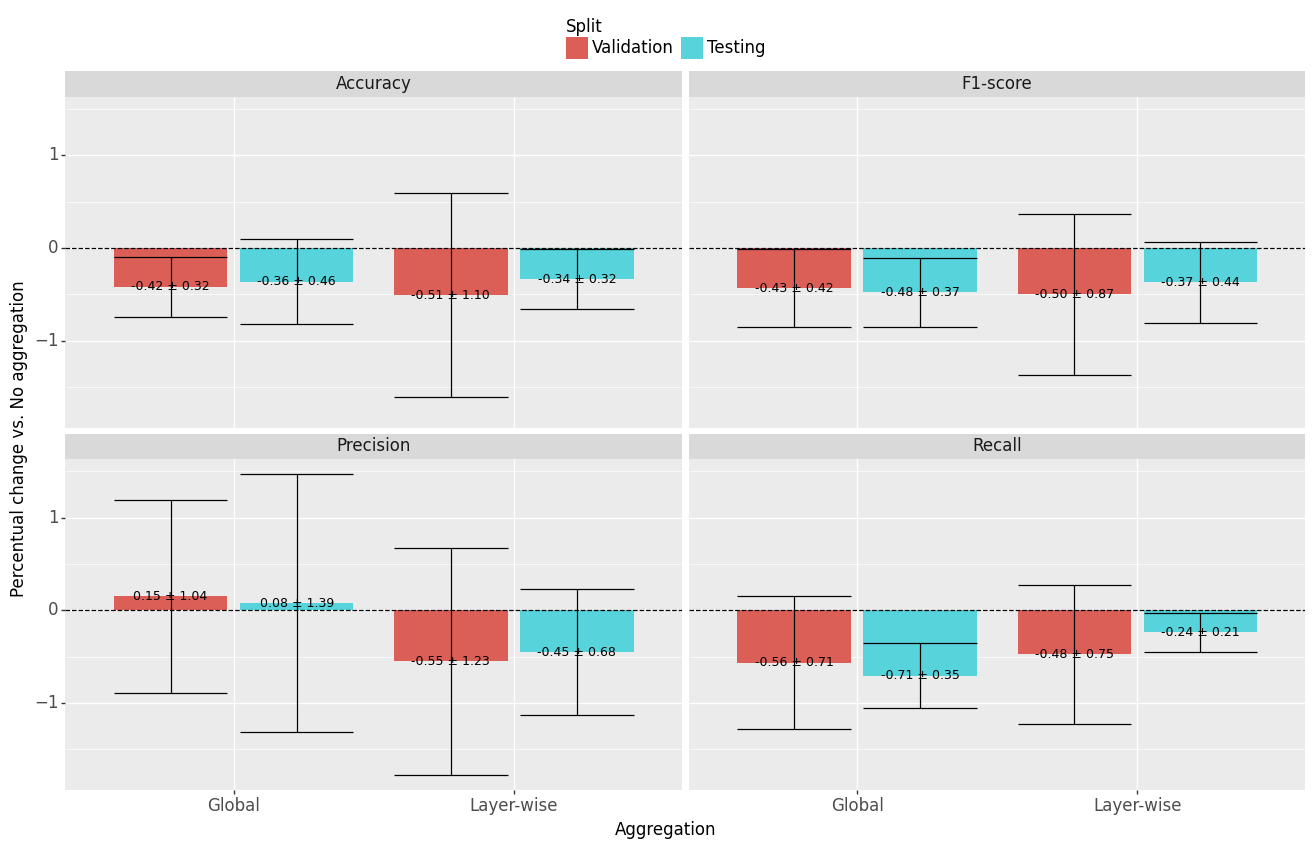

<ggplot: (814175812)>

In [48]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'aggregation', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Aggregation') + \
  p9.ylab('Percentual change vs. No aggregation') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

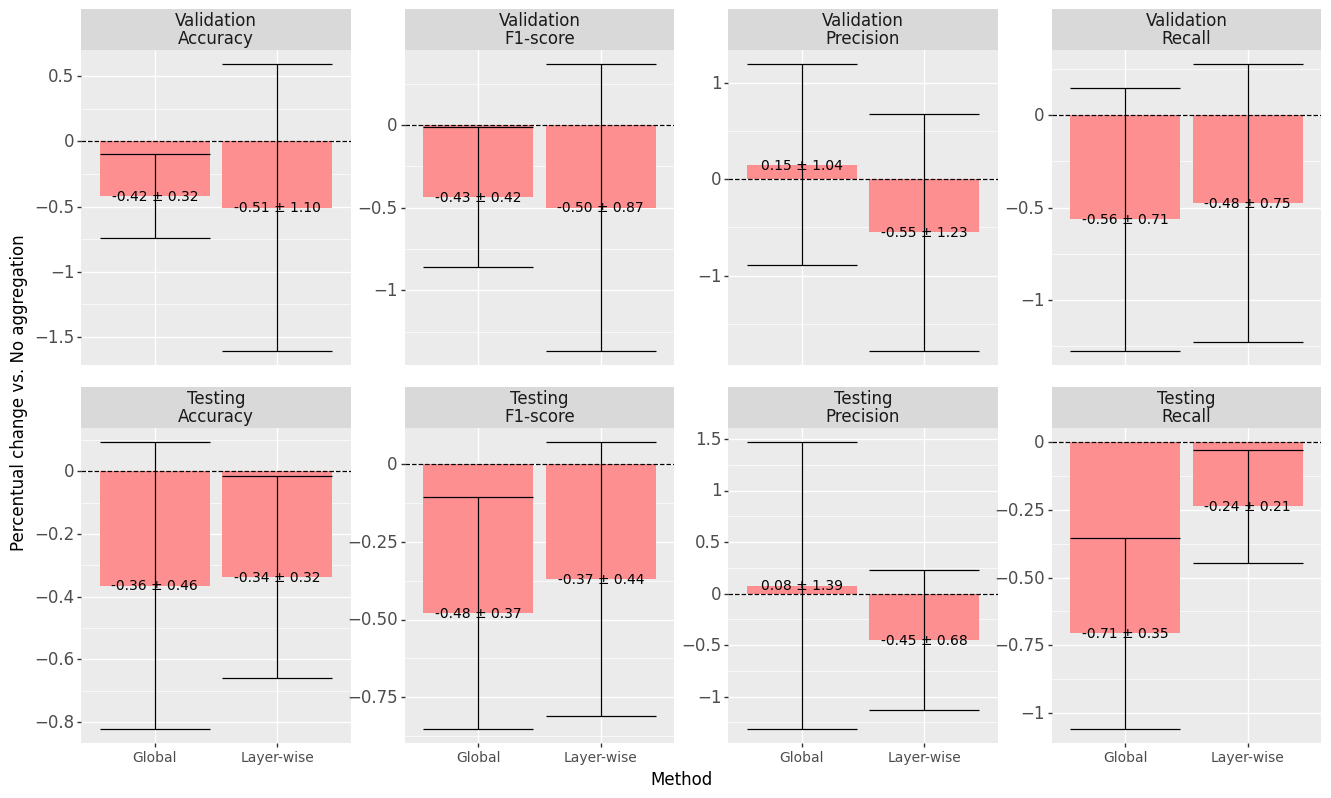

<ggplot: (815796387)>

In [49]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'aggregation', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Method') + \
  p9.ylab('Percentual change vs. No aggregation') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# Statistical significance

In [50]:
def get_best_results_for_statistics(datasets, gnns, llm, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for method in methods:
        for aggregation in aggregations:
          df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
          # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
          df = remove_trials_with_exceptions(df)
          
          df_aggregated = df.groupby(['trial', 'split']).agg({
            'accuracy' : ['mean', 'std'],
            'f1_score' : ['mean', 'std'],
            'precision' : ['mean', 'std'],
            'recall' : ['mean', 'std'],
          }).reset_index()
          df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
          
          best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
          best_trial = df[df['trial'] == best_trial_number]
          best_trial['target_metric'] = best_trial[target_metric]
          best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
          best_trial['dataset'] = dataset
          best_trial['gnn'] = gnn
          best_trial['method'] = method
          best_trial['aggregation'] = aggregation
          results.append(best_trial)

  return pd.concat(results, axis = 0)

In [51]:
stats_df = get_best_results_for_statistics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llm = 'google-bert-bert-base-uncased',
  methods = ['Grouped'],
  aggregations = ['No_Aggregation', 'Layer-wise_Aggregation', 'Global_Aggregation']
)

In [52]:
stats_df

,trial,random_state,split,target_metric,dataset,gnn,method,aggregation
0,221,42,validation,0.907110,SST-2,GATv2,Grouped,No_Aggregation
1,221,42,test,0.891818,SST-2,GATv2,Grouped,No_Aggregation
2,221,45,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation
3,221,45,test,0.897309,SST-2,GATv2,Grouped,No_Aggregation
4,221,44,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation
...,...,...,...,...,...,...,...,...
15,214,46,test,0.919403,IMDb-top_1000,GATv2,Grouped,Global_Aggregation
16,214,41,validation,0.909091,IMDb-top_1000,GATv2,Grouped,Global_Aggregation
17,214,41,test,0.925373,IMDb-top_1000,GATv2,Grouped,Global_Aggregation
18,214,40,validation,0.909091,IMDb-top_1000,GATv2,Grouped,Global_Aggregation


In [53]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[(stats_df['split'] == split)].drop(columns = ['trial', 'split', 'gnn', 'method']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'aggregation', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['Global_Aggregation', 'Layer-wise_Aggregation', 'No_Aggregation'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
Global_Aggregation - Layer-wise_Aggregation: Statistic: -0.06417728407043122 P-value: 0.949156892102516 Reject H0? False
Global_Aggregation - No_Aggregation: Statistic: -2.540963961513757 P-value: 0.015145627321479426 Reject H0? True
Layer-wise_Aggregation - No_Aggregation: Statistic: -2.3256607445431974 P-value: 0.025328852205830244 Reject H0? True

test
Global_Aggregation - Layer-wise_Aggregation: Statistic: -0.9803652615554331 P-value: 0.3329486054682237 Reject H0? False
Global_Aggregation - No_Aggregation: Statistic: -2.601141097461474 P-value: 0.013061560413684606 Reject H0? True
Layer-wise_Aggregation - No_Aggregation: Statistic: -1.6104752202490815 P-value: 0.11535949949348166 Reject H0? False

